# **SOPORTE: Proceso esquematizado para la realización del reto (Objetivo_1)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U pymgrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 47.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.2 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-1.2.2-py3-none-any.whl size=3492845 sha256=7890f939c0e64246532e57b2d9ff9f1069a1f7c8395f5db1f1592c2c39d97c37
  Stored in directory: /root/.cache/pip/wheels/aa/9c/34/d880763dcc693c67448303756a6e1adb899bdc0d5080643030
Successfully built pymgrid


In [ ]:
!pip install git+https://github.com/Wenuka/pymgrid/


  Cloning https://github.com/Wenuka/pymgrid/ to /tmp/pip-req-build-4_gs9hlz
  Running command git clone --filter=blob:none --quiet https://github.com/Wenuka/pymgrid/ /tmp/pip-req-build-4_gs9hlz
  Resolved https://github.com/Wenuka/pymgrid/ to commit 6a8091e1ee554c65bdb4bb229570aa94a3bf4a03
  Preparing metadata (setup.py) ... done
  Created wheel for pymgrid: filename=pymgrid-0.1.0-py3-none-any.whl size=3424052 sha256=8d19eb3716a169d7ce589e1a17007fefefddddd9dd1ba2603144e342d4c03f61
  Stored in directory: /tmp/pip-ephem-wheel-cache-o4lkzw69/wheels/cd/b4/15/71aa9cbda578c3c22dfcbc0fb165c27772f2099892ca060bd1
Successfully built pymgrid
  Attempting uninstall: pymgrid
    Found existing installation: pymgrid 1.2.2
    Uninstalling pymgrid-1.2.2:
      Successfully uninstalled pymgrid-1.2.2


In [ ]:
import gymnasium as gym

In [ ]:
import sys
from pymgrid import MicrogridGenerator as mg
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import matplotlib.pyplot as plt

!python --version

Python 3.11.11


Nota: Proceso para importar carpeta "data2" en colab

In [ ]:
# Selección de archivo (.zip) en Colab a partir de un cuadro de dialogo
from google.colab import files

archivo_subido = files.upload()


Saving data.zip to data.zip


In [ ]:
# Unzip del fichero seleccionado
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("./")

In [ ]:
env = mg.MicrogridGenerator(nb_microgrid=5, path="./data/pymgrid_data")  # we use a custom file to simulate the load and the PV
env.generate_microgrid(verbose=False)
mg0 = env.microgrids[0]
mg0.architecture

{'PV': 1, 'battery': 1, 'genset': 0, 'grid': 1}

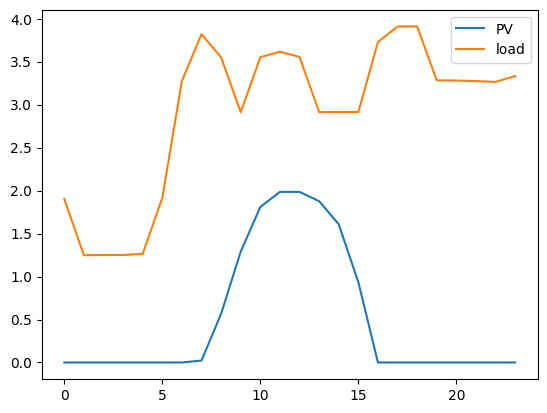

In [ ]:
plt.plot(mg0.forecast_pv(), label="PV")
plt.plot(mg0.forecast_load(), label="load")
plt.legend()

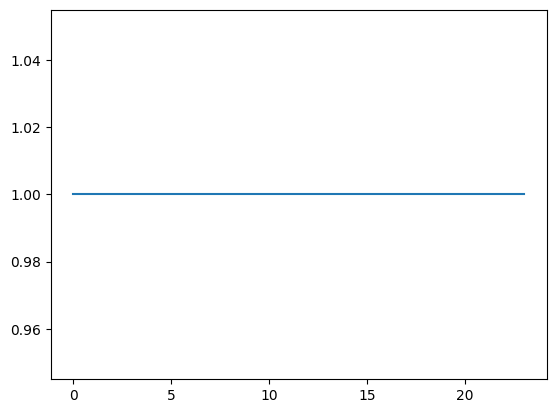

In [ ]:
plt.plot(mg0.forecast_grid_status())

**Lo estados podrían ser:**
- Carga (kW)
- FV (kW)
- Bateria (% carga)
- Conexión a red (constante siempre a 1)

Finalmente, podemos definir la carga de red como: carga - FV, así que realmente tenemos **"dos estados"**:

**(Net_load, battery %)**

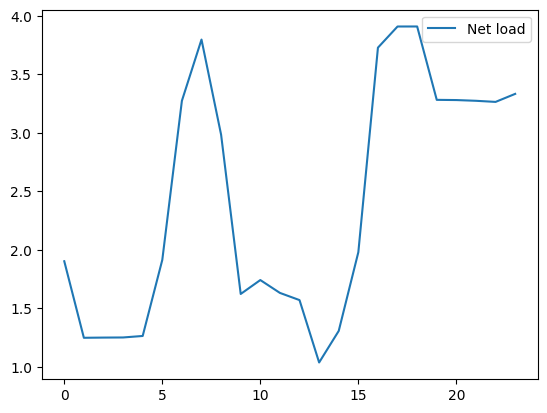

In [ ]:
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")
plt.legend()

Discretizamos el environment

Current load: 1.9025237435023625
Current PV: 0.0
Battery capacity: 16
Battery state of charge: 0.2


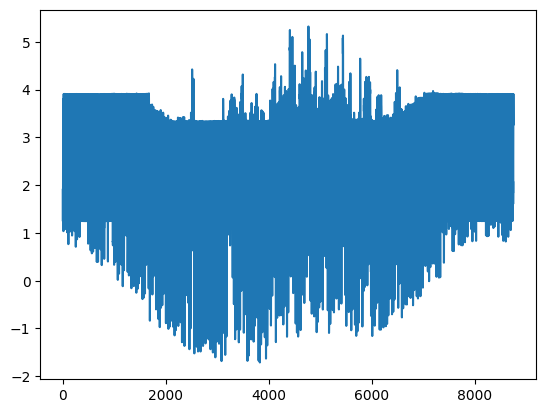

In [ ]:
mg0.set_horizon(24*365) # Intervalo de tiempo sobre el cual extraer datos
overall_net_load = mg0.forecast_load()-mg0.forecast_pv()
overal_min = min(overall_net_load)
overal_max = max(overall_net_load)
discretize_interval = 1
net_load_params = (overal_min, overal_max, discretize_interval) # Variable para llamar a función
plt.plot(mg0.forecast_load()-mg0.forecast_pv(), label="Net load")

current_load = mg0.load
current_pv = mg0.pv
battery_capacity = mg0.battery.capacity
battery_state_of_charge = mg0.battery.soc

print(f"Current load: {current_load}")
print(f"Current PV: {current_pv}")
print(f"Battery capacity: {battery_capacity}")
print(f"Battery state of charge: {battery_state_of_charge}")

**Discretizar:** Para aplicarQ-learning definimos estados discretos

**Acciones:**
- Action 0: cargar batería
- Action 1: descargar batería
- Action 2: comprar de la red
- Action 3: vender a la red

**Definimos las acciones, de acuerdo a lo indicado:**

Nota: "La manera o forma de aplicar estas acciones, será explicada en el reto para que no les de a duda de como calcular cada una de ellas.

In [ ]:
def actions_agent(mg0, action):
    pv = mg0.pv
    load = mg0.load
    net_load = load - pv

    # Calculamos parámetros de la bateria ###
    # Parámetros para la carga:
    capa_to_charge = mg0.battery.capa_to_charge  # remaining capacity to charge of the battery
    p_charge_max = mg0.battery.p_charge_max  # charge speed of the battery
    p_charge = max(0,min(-net_load, capa_to_charge, p_charge_max))  # Valor de carga para el periodo de tiempo definido (time stamp) charge value for the time
    # Parámetros para la descarga
    capa_to_discharge = mg0.battery.capa_to_discharge  # capacity of discharge
    p_discharge_max = mg0.battery.p_discharge_max  # per hour discharge rate
    p_discharge = max(0,min(net_load, capa_to_discharge, p_discharge_max))  # discharge value for the time

    if action == 0:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': p_charge,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':max(0,pv - min(pv,load) - p_charge)
                       }
    elif action ==1:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': p_discharge,
                        'grid_import': max(0,load - min(pv,load) - p_discharge),
                        'grid_export':0
                       }
    elif action ==2:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': abs(net_load),
                        'grid_export':0
                       }
    elif action == 3:
        control_dict = {'pv_consummed': min(pv,load),
                        'battery_charge': 0,
                        'battery_discharge': 0,
                        'grid_import': 0,
                        'grid_export':abs(net_load)
                       }

    return control_dict

**Inicializamos la Q-table:**

In [ ]:
!pip install stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
from gymnasium import spaces
import numpy as np
class MicrogridEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, microgrid, horizon=24*7):
        super().__init__()
        self.microgrid = microgrid
        self.horizon = horizon
        self.current_step = 0

        forecast_load = self.microgrid.forecast_load()
        forecast_pv = self.microgrid.forecast_pv()
        net_load = forecast_load - forecast_pv

        self.observation_space = spaces.Box(
            low=np.array([net_load.min(), 0.0], dtype=np.float32),
            high=np.array([net_load.max(), 1.0], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)

    def reset(self, seed=None, options=None):
        self.microgrid.reset()
        self.current_step = 0
        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        return np.array([net_load, soc], dtype=np.float32), {}

    def step(self, action):
        control_dict = actions_agent(self.microgrid, action)
        self.microgrid.run(control_dict)

        cost = self.microgrid.get_cost()
        reward = -cost

        self.current_step += 1
        done = self.current_step >= self.horizon

        net_load = self.microgrid.load - self.microgrid.pv
        soc = self.microgrid.battery.soc
        observation = np.array([net_load, soc], dtype=np.float32)

        return observation, reward, done, False, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Net Load: {self.microgrid.load - self.microgrid.pv}, Battery SOC: {self.microgrid.battery.soc}")

    def close(self):
        pass

In [ ]:
from stable_baselines3.common.env_checker import check_env


mg0 = env.microgrids[0]

env = MicrogridEnv(mg0)
env = Monitor(env)

check_env(env)

# ACTOR CRITIC

In [ ]:
import os
import pandas as pd
from stable_baselines3.common.monitor import Monitor

os.makedirs("./logs/", exist_ok=True)

env = Monitor(env, filename="./logs/monitor.csv")

from stable_baselines3 import A2C
model_a2c = A2C("MlpPolicy", env, verbose=1)
model_a2c.learn(total_timesteps=100000)
env.close()
model_a2c.save("a2c_microgrid")

log_path = "./logs/monitor.csv"
if os.path.exists(log_path):
    log_df = pd.read_csv(log_path, skiprows=1)
    print(log_df.head())
else:
    print("El archivo de log no se encontró en:", log_path)


Using cpu device
Wrapping the env in a DummyVecEnv.
-------------------------------------
| rollout/              |           |
|    ep_len_mean        | 168       |
|    ep_rew_mean        | -2.09e+03 |
| time/                 |           |
|    fps                | 253       |
|    iterations         | 100       |
|    time_elapsed       | 1         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -1.04     |
|    explained_variance | 0.204     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -2.08     |
|    value_loss         | 8.91      |
-------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 168      |
|    ep_rew_mean        | -1.3e+03 |
| time/                 |          |
|    fps                | 315      |
|    iterations         | 200      |
|    time_elapsed       | 3        |
|    t

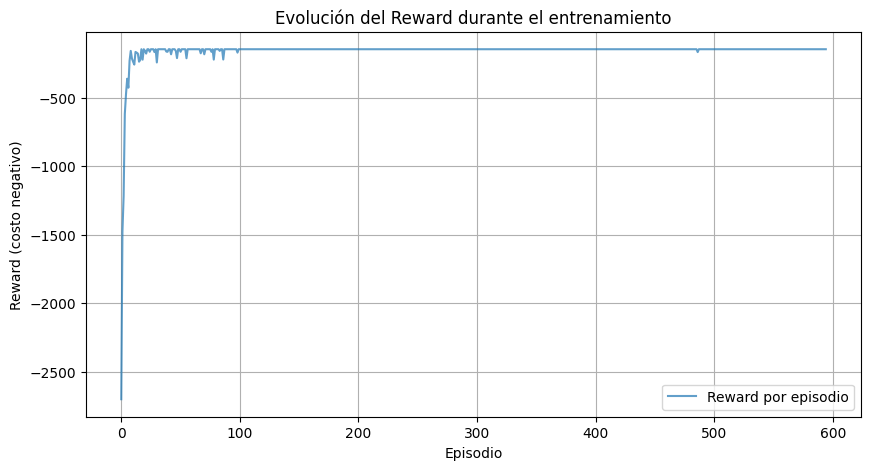

In [ ]:
log_df = pd.read_csv("./logs/monitor.csv", skiprows=1)

plt.figure(figsize=(10, 5))
plt.plot(log_df.index, log_df["r"], label="Reward por episodio", alpha=0.7)
plt.xlabel("Episodio")
plt.ylabel("Reward (costo negativo)")
plt.title("Evolución del Reward durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(f"Reward final: {log_df['r'].iloc[-1]}")

Reward final: -146.774124


## TESTEO DEL A2C

In [ ]:
archivo_subido = files.upload()

with zipfile.ZipFile("data4.zip", 'r') as zip_ref:
    zip_ref.extractall("./")
env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data4/pymgrid_data")

Saving data4.zip to data4.zip


In [ ]:
archivo_subido = files.upload()

with zipfile.ZipFile("data_pv_low_load_high.zip", 'r') as zip_ref:
    zip_ref.extractall("./data_pv_low_load_high")

env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")

Saving data_pv_low_load_high.zip to data_pv_low_load_high.zip


In [ ]:
import pytest
import copy

env_gen = mg.MicrogridGenerator(nb_microgrid=5,  path="./data/pymgrid_data")
env_test1 = mg.MicrogridGenerator(nb_microgrid=5, path="./data4/pymgrid_data")
env_test2 = mg.MicrogridGenerator(nb_microgrid=5, path="./data_pv_low_load_high/data_pv_low_load_high/data/pymgrid_data")

def simulate_env(model, microgrid, num_episodes=50):
    """
    Ejecuta num_episodes en el entorno creado a partir del microgrid y retorna el reward promedio.
    """
    simulation_env = MicrogridEnv(microgrid)
    simulation_env = Monitor(simulation_env)
    rewards = []

    for episode in range(num_episodes):
        obs, _ = simulation_env.reset()
        done = False
        episode_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = simulation_env.step(action)
            episode_reward += reward
        rewards.append(episode_reward)

    return np.mean(rewards)

@pytest.fixture
def trained_model_and_microgrid():
    """
    Fixture que carga el modelo entrenado y genera el microgrid a partir del entorno de entrenamiento.
    """
    env_gen.generate_microgrid(verbose=False)
    mg0 = env_gen.microgrids[0]
    model = A2C.load("a2c_microgrid")
    return model, mg0

def test_increased_load(trained_model_and_microgrid):
    """
    Test metamórfico para comprobar que al aumentar la carga el coste global es mayor.
    Dado que el reward es -cost, se espera que el avg_reward disminuya.
    """
    model, mg0 = trained_model_and_microgrid

    avg_reward_orig = simulate_env(model, mg0, num_episodes=50)

    env_test2.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test2.microgrids[0])

    avg_reward_mod = simulate_env(model, mg_mod, num_episodes=50)

    assert avg_reward_mod < avg_reward_orig, (
        f"Con carga aumentada se esperaba un avg_reward menor (más negativo). "
        f"avg_reward original: {avg_reward_orig}, avg_reward modificado: {avg_reward_mod}"
    )

    print(f"Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")

def test_increased_pv(trained_model_and_microgrid):
    """
    Test metamórfico para comprobar que al aumentar la generación fotovoltaica el coste global es menor.
    Es decir, se espera que el avg_reward aumente.
    """
    model, mg0 = trained_model_and_microgrid

    avg_reward_orig = simulate_env(model, mg0, num_episodes=50)

    env_test1.generate_microgrid(verbose=False)
    mg_mod = copy.deepcopy(env_test1.microgrids[0])

    avg_reward_mod = simulate_env(model, mg_mod, num_episodes=50)

    assert avg_reward_mod > avg_reward_orig, (
        f"Con PV aumentada se esperaba un avg_reward mayor. "
        f"avg_reward original: {avg_reward_orig}, avg_reward modificado: {avg_reward_mod}"
    )

    print(f"Test 'increased pv' passed: al aumentar la generación PV, el coste global es menor. Coste medio original: {avg_reward_orig}. Coste medio modificado: {avg_reward_mod}")


In [ ]:
!pip install ipytest


In [ ]:
import ipytest
ipytest.autoconfig()
ipytest.run("--maxfail=2", "--disable-warnings", "-s")

Test 'increased load' passed: al aumentar la carga, el coste global es mayor. Coste medio original: -146.77412390930056. Coste medio modificado: -291.93767141560636
.F
============================================= FAILURES =============================================
________________________________________ test_increased_pv _________________________________________

trained_model_and_microgrid = (<stable_baselines3.a2c.a2c.A2C object at 0x7c1afbe43f50>, <pymgrid.Microgrid.Microgrid object at 0x7c1afc13ab90>)

    def test_increased_pv(trained_model_and_microgrid):
        """
        Test metamórfico para comprobar que al aumentar la generación fotovoltaica el coste global es menor.
        Es decir, se espera que el avg_reward aumente.
        """
        model, mg0 = trained_model_and_microgrid
    
        # Obtener el reward promedio con la configuración original
        avg_reward_orig = simulate_env(model, mg0, num_episodes=50)
    
        # Generar un nuevo microgrid del ento

<ExitCode.TESTS_FAILED: 1>